In [12]:
import os
import glob
import numpy as np
import librosa
import soundfile
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from librosa import display
import IPython.display as ipd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [13]:
#Emotions in the RAVDESS dataset
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [14]:
path = "/home/iases/code/pankaj-lewagon/ser/raw_data/ravdess_data"

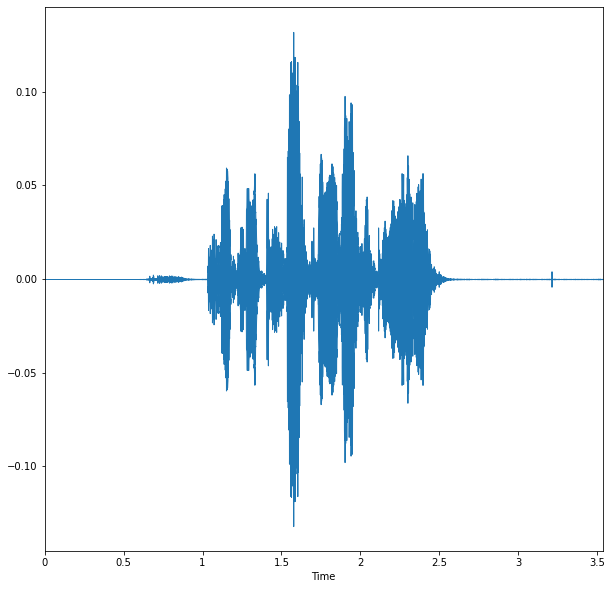

In [15]:
file = path + '/Actor_02/03-01-08-01-01-01-02.wav'

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
data, sample_rate = librosa.load(file)
librosa.display.waveplot(data, sr=sample_rate)
ipd.Audio(file)



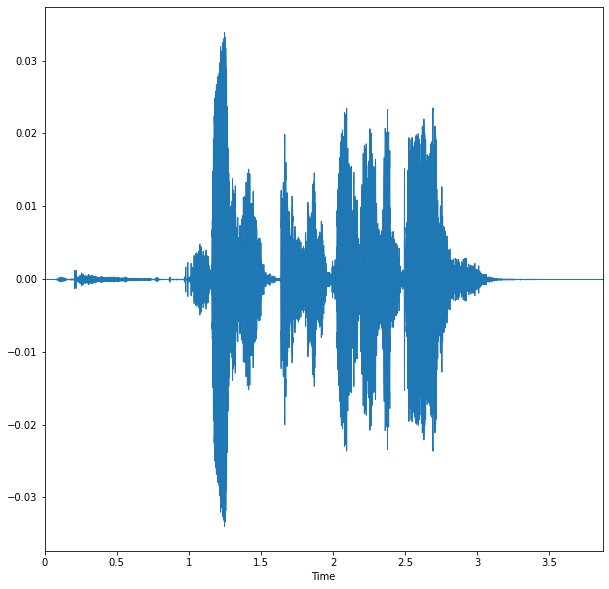

In [16]:
file = path + '/Actor_01/03-01-07-01-01-01-01.wav'

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
data, sample_rate = librosa.load(file)
librosa.display.waveplot(data, sr=sample_rate)
ipd.Audio(file)


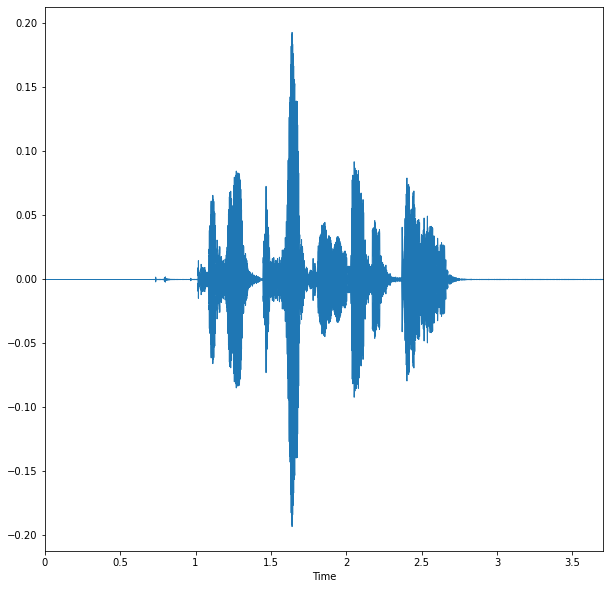

In [17]:
file = path + '/Actor_04/03-01-05-01-01-01-04.wav'

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
data, sample_rate = librosa.load(file)
librosa.display.waveplot(data, sr=sample_rate)
ipd.Audio(file)


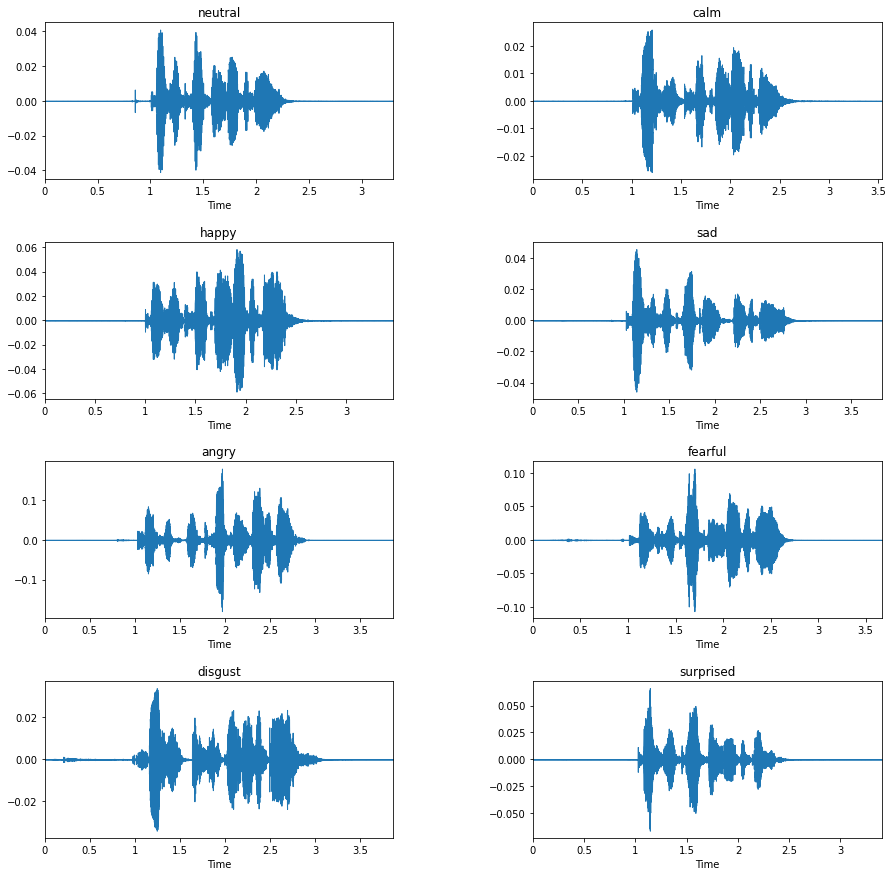

In [18]:
fig = plt.figure(figsize=(15,15))# Log graphic of waveforms to Comet

fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in emotions.keys():
  filename = path + f'/Actor_01/03-01-{i}-01-01-01-01.wav'
  fig.add_subplot(4, 2, int(i))
  plt.title(emotions[i])
  data, sample_rate = librosa.load(filename)
  librosa.display.waveplot(data, sr=sample_rate)




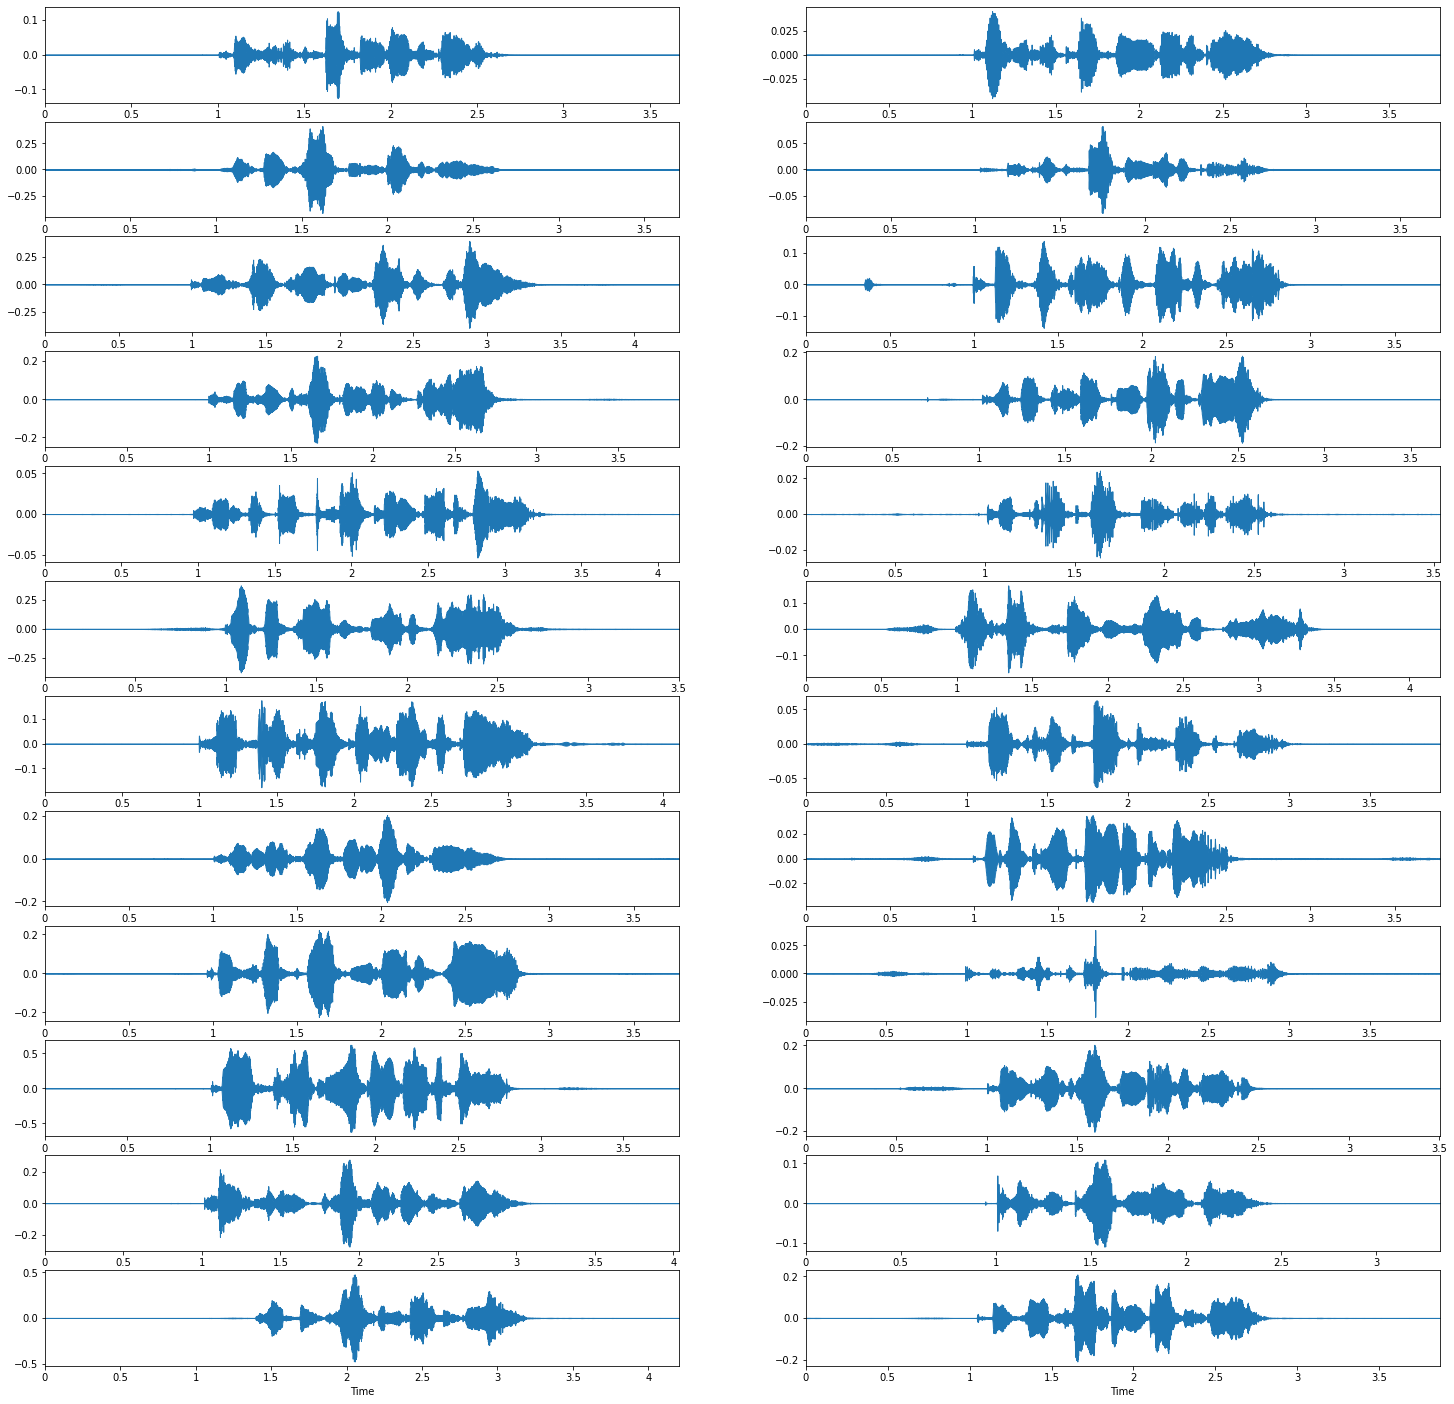

In [19]:
#happy and sad waveforms for first 12 actors

fig = plt.figure(figsize=(25,25))# Log graphic of waveforms to Comet

for i in range(12):

  if i<9:
    stringlet = f'0{str(i+1)}'
  else:
    stringlet = str(i+1)

  filename1 = path + f'/Actor_{stringlet}/03-01-03-02-01-01-{stringlet}.wav'
  filename2 = path + f'/Actor_{stringlet}/03-01-04-02-01-01-{stringlet}.wav'
  fig.add_subplot(12, 2, 2*(i+1)-1)
  data1, sample_rate1 = librosa.load(filename1)
  librosa.display.waveplot(data1, sr=sample_rate1)
  fig.add_subplot(12,2, 2*(i+1))
  data2, sample_rate2 = librosa.load(filename2)
  librosa.display.waveplot(data2, sr=sample_rate2)

## Base-model

**mfcc**: Mel Frequency Cepstral Coefficient, represents the short-term power spectrum of a sound - 40 features\
**chroma**: Pertains to the 12 different pitch classes - 12 features\
**mel**: Mel Spectrogram Frequency - 128 features\
**temp**: tempogram (rhythm feature) - 384 features

In [20]:
def extract_feature(file_name, mfcc, chroma, mel, temp):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
        if temp:
            temp=np.mean(librosa.feature.tempogram(y=X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, temp))   
    return result

In [21]:
def load_data():
    x, y = [], []
    for file in glob.glob(path+"/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        feature = extract_feature(file, mfcc=True, chroma=False, mel=False, temp=True)
        x.append(feature)
        y.append(emotion)
    return x, y  

In [22]:
x, y = load_data()

np.array(x).shape

/home/iases/.pyenv/versions/3.8.6/envs/ser_proj/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


(1440, 424)

In [23]:
emotion_numbers = pd.DataFrame(data=y).value_counts()
emotion_numbers

angry        192
calm         192
disgust      192
fearful      192
happy        192
sad          192
surprised    192
neutral       96
dtype: int64

In [24]:
emotion_numbers.max()/len(y) #baseline score = 192/1440

0.13333333333333333

In [25]:
# train-test split, instantiate model, fit model

x_train, x_test, y_train, y_test = train_test_split(np.array(x), y, test_size=0.2, random_state=9)

#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(activation='logistic', alpha=0.01, batch_size=32, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

model.fit(x_train,y_train)

MLPClassifier(activation='logistic', alpha=0.01, batch_size=32,
              hidden_layer_sizes=(300,), learning_rate='adaptive',
              max_iter=500)

In [26]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.6597222222222222

In [27]:
precision_score(y_test, y_pred, average='micro')

0.6597222222222222

In [28]:
cross_val_score(model, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)[0].mean()

0.6493506493506493

## Confusion matrix

In [29]:
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

In [30]:
actual = y_test
predictions = y_pred

In [31]:
print(classification_report(actual, predictions, target_names = ['neutral','calm','happy','sad','angry','fearful','disgust','surprised']))

              precision    recall  f1-score   support

     neutral       0.79      0.70      0.74        47
        calm       0.70      0.70      0.70        44
       happy       0.72      0.74      0.73        35
         sad       0.64      0.72      0.68        32
       angry       0.46      0.39      0.43        33
     fearful       0.32      0.40      0.35        15
     disgust       0.75      0.63      0.69        52
   surprised       0.64      0.83      0.72        30

    accuracy                           0.66       288
   macro avg       0.63      0.64      0.63       288
weighted avg       0.67      0.66      0.66       288



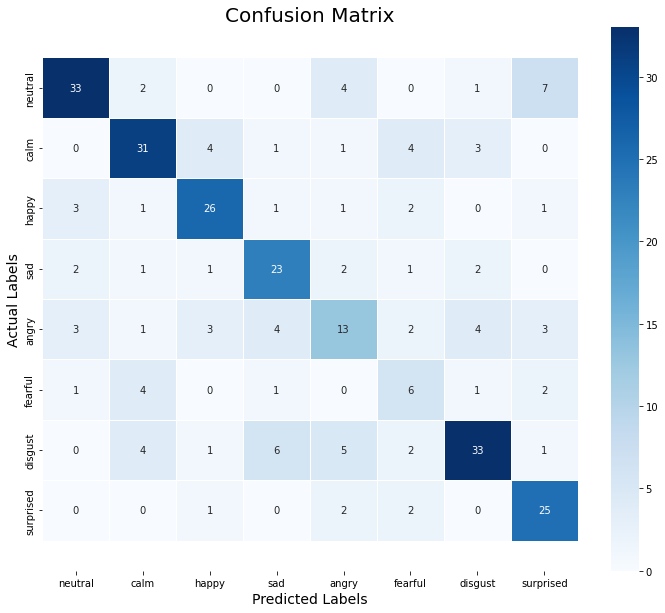

In [32]:
# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [emotion for emotion in emotions.values()] , columns = [emotion for emotion in emotions.values()])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

## Increasing the accuracy

In [33]:
#Reduce the number of emotions by combining neutral, calm, sad into 'calm'
emotions = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

observed_emotions = ['calm','happy','sad','angry','fearful','disgust']

In [34]:
#Drop 'surprised' and select only two features: mfcc and temp
def load_data(test_size=0.2):
    x, y = [], []
    for file in glob.glob(path+"/Actor_*/*.wav"):
        file_name = os.path.basename(file)
        emotion = emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        else:
            feature = extract_feature(file, mfcc=True, chroma=False, mel=True, temp=True)
            x.append(feature)
            y.append(emotion)
    return x, y  

In [35]:
x, y = load_data(path)

np.array(x).shape

/home/iases/.pyenv/versions/3.8.6/envs/ser_proj/lib/python3.8/site-packages/librosa/filters.py:238: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  warnings.warn(


(1152, 552)

In [36]:
emotion_numbers = pd.DataFrame(data=y).value_counts()
emotion_numbers

angry      192
calm       192
disgust    192
fearful    192
happy      192
sad        192
dtype: int64

In [37]:
emotion_numbers.max()/len(y) #baseline score

0.16666666666666666

In [38]:
# as before, but model uses activation 'logistic' rather than 'relu', and batch_size=32 rather than 256

x_train, x_test, y_train, y_test = train_test_split(np.array(x), y, test_size=0.2, random_state=9)

#Initialize the Multi Layer Perceptron Classifier
model=MLPClassifier(activation='logistic', alpha=0.01, batch_size=32, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)


model.fit(x_train,y_train)

y_pred = model.predict(x_test)

accuracy_score(y_test, y_pred)

0.7445887445887446

In [39]:
cross_val_score(model, x_train, y_train, scoring='accuracy', cv=5, n_jobs=-1)[0].mean()

0.7081081081081081

In [40]:
precision_score(y_test, y_pred, average='macro')

0.7538164360532781

In [41]:
emotion_list = observed_emotions
emotion_list.sort()
model_pred_prob = pd.DataFrame((model.predict_proba(x_test)*100).round(2), columns=emotion_list)
model_pred_prob['prediction'] = y_pred
model_pred_prob['actual']=y_test
model_pred_prob.head()

,angry,calm,disgust,fearful,happy,sad,prediction,actual
0,1.17,8.98,0.73,42.37,2.80,43.96,sad,sad
1,0.10,98.31,0.97,0.23,0.00,0.37,calm,calm
2,14.26,0.01,4.45,0.05,0.01,81.23,sad,disgust
3,0.06,0.02,0.02,0.01,99.89,0.01,happy,happy
4,1.20,0.05,3.25,56.81,38.67,0.02,fearful,happy


              precision    recall  f1-score   support

       angry       0.74      0.82      0.78        34
        calm       0.68      0.79      0.73        34
     disgust       0.78      0.76      0.77        38
     fearful       0.73      0.80      0.76        40
       happy       0.89      0.60      0.72        40
         sad       0.71      0.71      0.71        45

    accuracy                           0.74       231
   macro avg       0.75      0.75      0.75       231
weighted avg       0.76      0.74      0.74       231



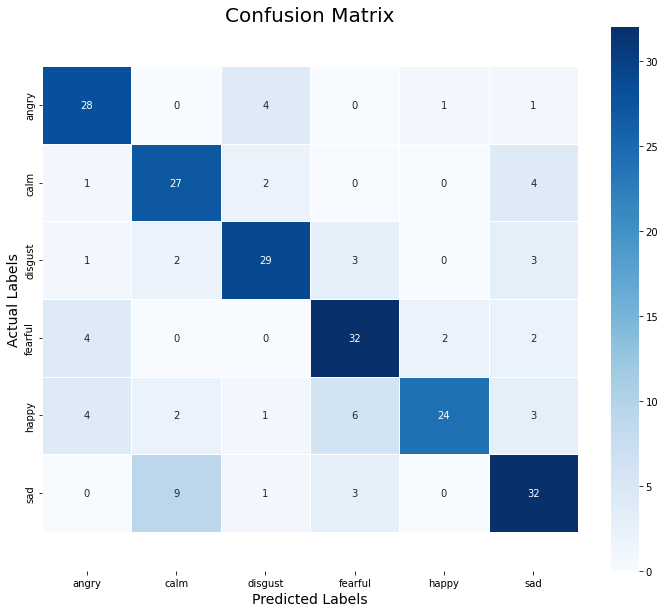

In [43]:
actual = y_test
predictions = y_pred

print(classification_report(actual, predictions, target_names = observed_emotions))

# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [emotion for emotion in observed_emotions] , columns = [emotion for emotion in observed_emotions])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()

## Does the model generalise?

In [44]:
path2 = "/home/iases/code/pankaj-lewagon/ser/raw_data/TESS"

In [45]:
path2
path2+f"/*AF_x/*.wav"

'/home/iases/code/pankaj-lewagon/ser/raw_data/TESS/*AF_x/*.wav'

In [46]:
emotions

{'01': 'neutral',
 '02': 'calm',
 '03': 'happy',
 '04': 'sad',
 '05': 'angry',
 '06': 'fearful',
 '07': 'disgust',
 '08': 'surprised'}

In [47]:
emotion_labels = ['angry', 'disgust', 'Fear', 'happy', 'neutral', 'Sad']


def load_data2():
    x_tess, y_tess = [], []
    for emotion_label in emotion_labels:
        for file2 in glob.glob(path2+f"/*AF_{emotion_label}/*.wav"):
            #print(file2)
            if emotion_label == 'Fear':
                emotion = 'fearful'
            elif emotion_label == 'neutral':
                emotion = 'calm'
            else:
                emotion = emotion_label.lower()

            feature = extract_feature(file2, mfcc=True, chroma=False, mel=True, temp=True)
            x_tess.append(feature)
            y_tess.append(emotion)
    return x_tess, y_tess  

In [48]:
x_tess, y_tess = load_data2()

In [49]:
np.array(x_tess).shape, len(y_tess)

((2000, 552), 2000)

In [50]:
y_tess_pred = model.predict(x_tess)

accuracy_score(y_tess, y_tess_pred)

0.309

In [51]:
precision_score(y_tess, y_tess_pred, average='macro')

0.2877717713107953

In [52]:
emotion_list = observed_emotions
emotion_list.sort()
model_pred_prob = pd.DataFrame((model.predict_proba(x_tess)*100).round(2), columns=emotion_list)
model_pred_prob['prediction'] = y_tess_pred
model_pred_prob['actual']=y_tess
model_pred_prob[model_pred_prob['actual']=='sad']

,angry,calm,disgust,fearful,happy,sad,prediction,actual
1800,0.99,5.02,0.07,39.20,0.01,54.71,sad,sad
1801,0.12,0.35,1.79,27.39,0.00,70.35,sad,sad
1802,0.00,0.15,0.02,40.08,0.00,59.75,sad,sad
1803,0.00,0.06,0.00,0.13,0.00,99.80,sad,sad
1804,0.00,0.05,1.62,7.67,0.00,90.65,sad,sad
...,...,...,...,...,...,...,...,...
1995,0.01,0.00,0.04,98.64,0.00,1.31,fearful,sad
1996,0.01,4.22,9.38,1.31,0.01,85.08,sad,sad
1997,0.00,0.80,0.00,0.17,0.00,99.02,sad,sad
1998,0.03,18.04,0.04,15.67,0.01,66.20,sad,sad


              precision    recall  f1-score   support

       angry       0.47      0.48      0.48       400
        calm       0.00      0.00      0.00       400
     disgust       0.34      0.32      0.33       400
     fearful       0.18      0.81      0.30       200
       happy       0.29      0.01      0.01       400
         sad       0.44      0.67      0.53       200

    accuracy                           0.31      2000
   macro avg       0.29      0.38      0.27      2000
weighted avg       0.28      0.31      0.25      2000



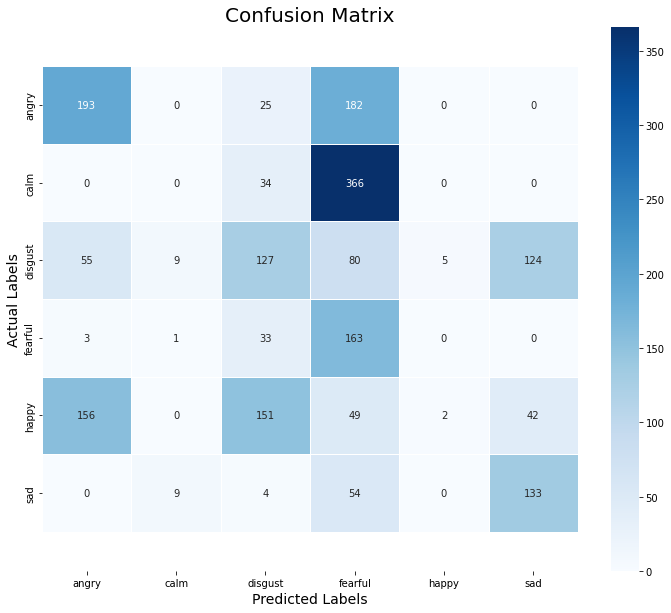

In [53]:
actual = y_tess
predictions = y_tess_pred

print(classification_report(actual, predictions, target_names = observed_emotions))

# CREATE CONFUSION MATRIX OF ACTUAL VS. PREDICTION 
cm = confusion_matrix(actual, predictions)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [emotion for emotion in observed_emotions] , columns = [emotion for emotion in observed_emotions])
ax = sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('Initial_Model_Confusion_Matrix.png')
plt.show()